In [73]:
%matplotlib notebook 
#magic comment - enables new interface for generated figures

import numpy as np
from math import sqrt
from math import ceil
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata

### Variables

In [89]:
#############################################################################################
# CHANGE ME!
#############################################################################################

numTilesX = 4
numTilesY = 3

# put numValX * numValY values 
#values = [ 256, 256,
#           128, 0 ] 

#values = [ 0, 0, 256,
#           128, 256, 256,
#            256, 100, 0 ] 

values = [ 0.000, 0.078, 0.000, 1.000, 0.500, 1.000, 
           0.391, 0.781, 0.125, 0.500, 0.250, 0.609, 
           0.000, 0.391, 0.250, 0.656, 0.000, 0.391,
           1.000, 0.078, 0.500, 0.078, 0.500, 0.078]

# number of levels drawn in the graph
numlevels = 32
  
#grid resolution
n = 256

#possible colormap values: { plt.cm.viridis, plt.cm.inferno, plt.cm.plasma, plt.cm.magma, plt.cm.YlGnBu, plt.cm.RdYlBu }
#find more colormaps at http://matplotlib.org/users/colormaps.html
colormap = plt.cm.inferno
figuresize = (numTilesX * 2, numTilesY * 2)
        
#############################################################################################

eps = 1e-4

numValX = 6 #numTilesX + 1
numValY = 4 #numTilesY + 1

minval = min(values)
maxval = max(values)
valrange = maxval - minval

levels = np.linspace(minval - valrange/2, maxval + valrange/2, numlevels*2)

#number of values represented by one level
valuesperlevel = (maxval - minval) / numlevels

#size of one tile
dx = (1.0 / numTilesX)
dy = (1.0 / numTilesY)

X3D = []
Y3D = []
Z3D = []

# Bilinear Interpolation

<IPython.core.display.Javascript object>


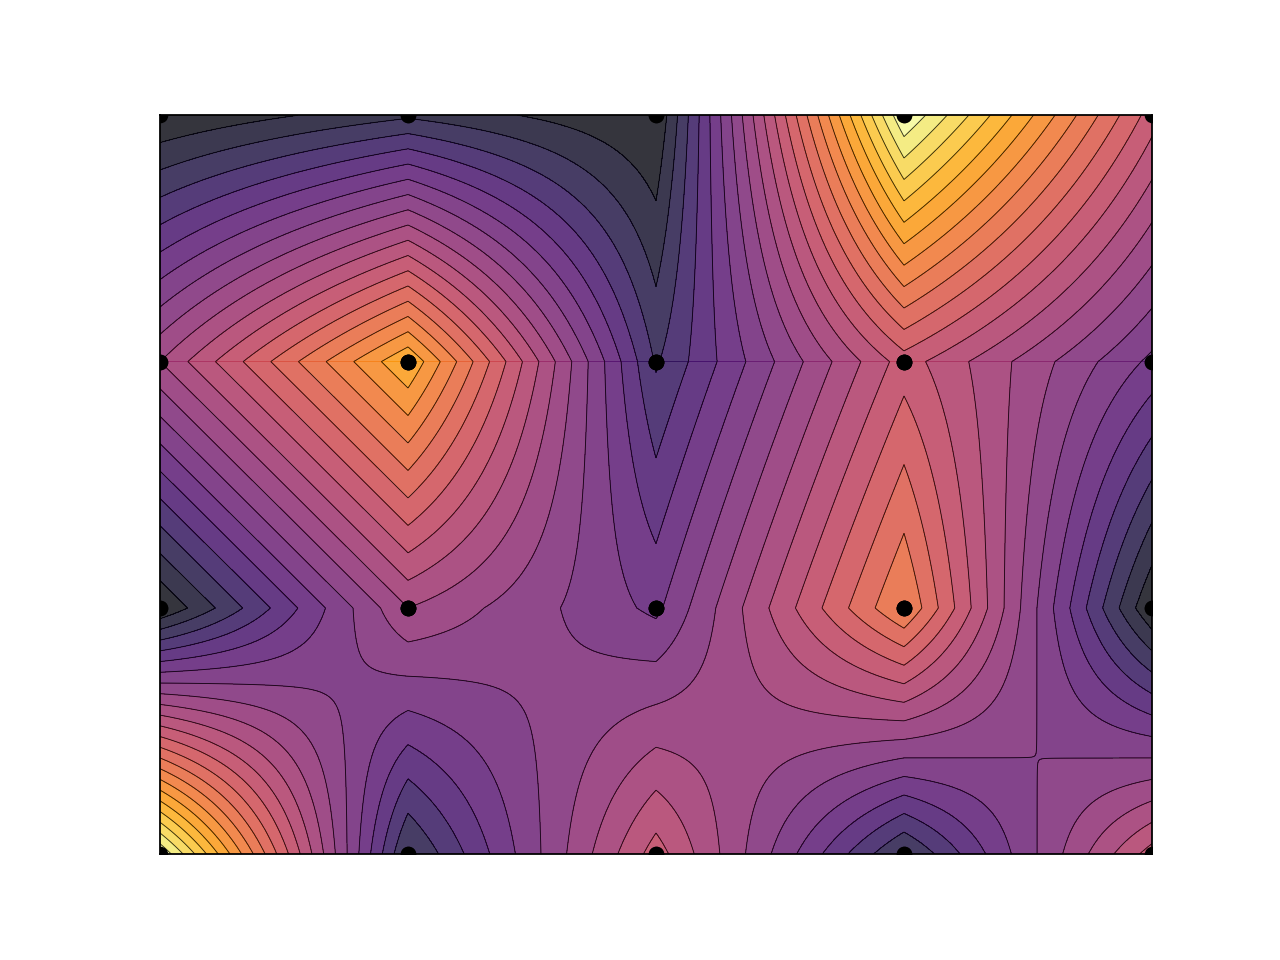

In [75]:
## BILINEAR INTERPOLATION

#figure size
bilinear = plt.figure(figsize = figuresize, dpi = 128)

#interpolation functions
def interp_y1(x): #linear interpolation in x-direction at y1 position
    return (x2 - x) / dx * Q11 + (x - x1) / dx * Q21

def interp_y2(x):  #linear interpolation in x-direction at y2 position
    return (x2 - x) / dx * Q12 + (x - x1) / dx * Q22

def lininterp(x, y): #combine all interpolations
    return (y2 - y) / dy * interp_y1(x) + (y - y1) / dy * interp_y2(x)
        
# plot the tiles
for tileX in range( 0, numTilesX ):
    for tileY in range( 0, numTilesY ):
        # values at corner of tile
        Q11 = values[(tileY+1) * numValX + tileX]   # Q11 = (x1, y1) - bottom left
        Q12 = values[tileY * numValX + tileX]       # Q12 = (x1, y2) - top left 
        Q21 = values[(tileY+1) * numValX + tileX+1] # Q21 = (x2, y1) - bottom right
        Q22 = values[tileY * numValX + tileX+1]     # Q11 = (x2, y2) - top right
        
        #tile position
        x1 = 0.0 + tileX * dx
        x2 = x1 + dx

        y2 = 1.0 - tileY * dy
        y1 = y2 - dy

        x = np.linspace(x1, x2, n)
        y = np.linspace(y1, y2, n)
        X,Y = np.meshgrid(x, y)

        #write current values to arrays for 3D surface mesh
        X3D.extend(X)
        Y3D.extend(Y)
        Z3D.extend(lininterp(X,Y))
        
        #plot colors for equal values
        plt.contourf(X, Y, lininterp(X, Y), levels, alpha=.8, cmap = colormap, vmin = minval, vmax = maxval)
        
        #show lines in contour plot
        C = plt.contour(X, Y, lininterp(X, Y), levels, colors = 'black', alpha=.8, linewidths = 0.4)
        
        #show labels in contour plot
        #plt.clabel(C, inline = 1, fontsize = 7, fmt = '%.2f')

        #plot points at corners
        plt.plot([x1, x2, x1, x2], [y1, y1, y2, y2], 'ko')
plt.xticks([])
plt.yticks([])
bilinear.show()
#plt.xticks(np.linspace(0, 1, numValX, endpoint = True))
#plt.yticks(np.linspace(0, 1, numValY, endpoint = True))

#plot as 3D height field
# fig2 = plt.figure(figsize = (6, 5), dpi = 120)
# ax = fig2.gca(projection = '3d')
# surf = ax.plot_surface(X3D, Y3D, Z3D, alpha=.8, cmap = colormap )

# Piecewise Linear Interpolation

<IPython.core.display.Javascript object>


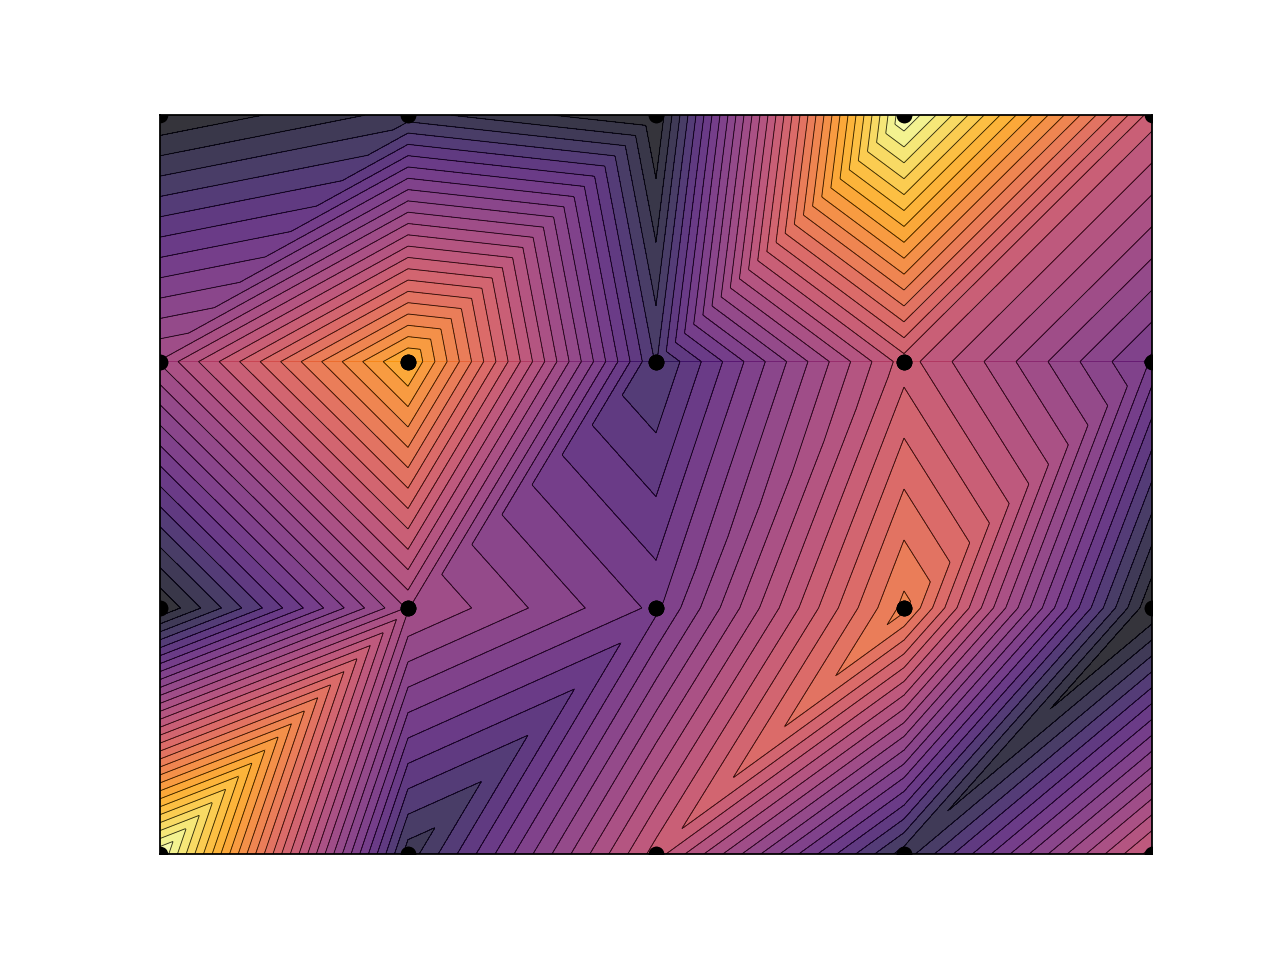

In [88]:
## PIECEWISE LINEAR INTERPOLATION

#figure size
piecewise_linear = plt.figure(figsize = figuresize, dpi = 128)
#interpolation functions
def interp_xl(y): #linear interpolation in x-direction at y1 position
    return (1 - y) * Q11 + y * Q12

def interp_xr(y): #linear interpolation in x-direction at y1 position
    return (1 - y) * Q21 + y * Q22

def interp_diag(d):
    return (1 - d) * Q11 + d * Q22

def isTL(x, y):
    return ((x - y) <= 0)*1

def isBR(x, y):
    return ((x - y) > 0)*1

def lininterp(x, y): #combine all interpolations
    cx = (x - x1)/dx
    cy = (y - y1)/dy
    
    d = cy
    
    alphaTL_indexes = np.where(d > eps)
    alphaTL = np.zeros((n,n))
    alphaTL[alphaTL_indexes] = cx[alphaTL_indexes] / d[alphaTL_indexes]

    alphaBR_indexes = np.where(d < (1-eps))
    alphaBR = np.ones((n,n))
    alphaBR[alphaBR_indexes] = (cx[alphaBR_indexes] - d[alphaBR_indexes])/(1 - d[alphaBR_indexes])
    
    #alphaBR = (cx - d)/(1 - d)
    tl = isTL(cx, cy)
    return tl * (alphaTL * interp_diag(cy) + (1 - alphaTL) * interp_xl(cy)) +\
    (1 - tl) * (alphaBR * interp_xr(cy) + (1 - alphaBR) * interp_diag(cy))
      
# plot the tiles
for tileY in range( 0, numTilesY ):
    for tileX in range( 0, numTilesX ):
        # values at corner of tile
        Q11 = values[(tileY+1) * numValX + tileX]   # Q11 = (x1, y1) - bottom left
        Q12 = values[tileY * numValX + tileX]       # Q12 = (x1, y2) - top left 
        Q21 = values[(tileY+1) * numValX + tileX+1] # Q21 = (x2, y1) - bottom right
        Q22 = values[tileY * numValX + tileX+1]     # Q22 = (x2, y2) - top right
        
        #tile position
        x1 = 0.0 + tileX * dx
        x2 = x1 + dx
        y2 = 1.0 - tileY * dy
        y1 = y2 - dy

        x = np.linspace(x1, x2, n)
        y = np.linspace(y1, y2, n)
        
        X,Y = np.meshgrid(x, y)   
        Z = lininterp(X, Y)
        
        #plot colors for equal values
        plt.contourf(X, Y, Z, levels, alpha=.8, cmap = colormap, vmin = minval, vmax = maxval)
        
        #show lines in contour plot
        C = plt.contour(X, Y, Z, levels, colors = 'black', alpha=.8, linewidths = 0.4)
        
        #show labels in contour plot
        #plt.clabel(C, inline = 1, fontsize = 7, fmt = '%.2f')

        #plot points at corners
        plt.plot([x1, x2, x1, x2], [y1, y1, y2, y2], 'ko')
plt.xticks([])
plt.yticks([])
piecewise_linear.show()
#plt.xticks(np.linspace(0, 1, numValX, endpoint = True))
#plt.yticks(np.linspace(0, 1, numValY, endpoint = True))

# Nearest Neighbor Interpolation

<IPython.core.display.Javascript object>


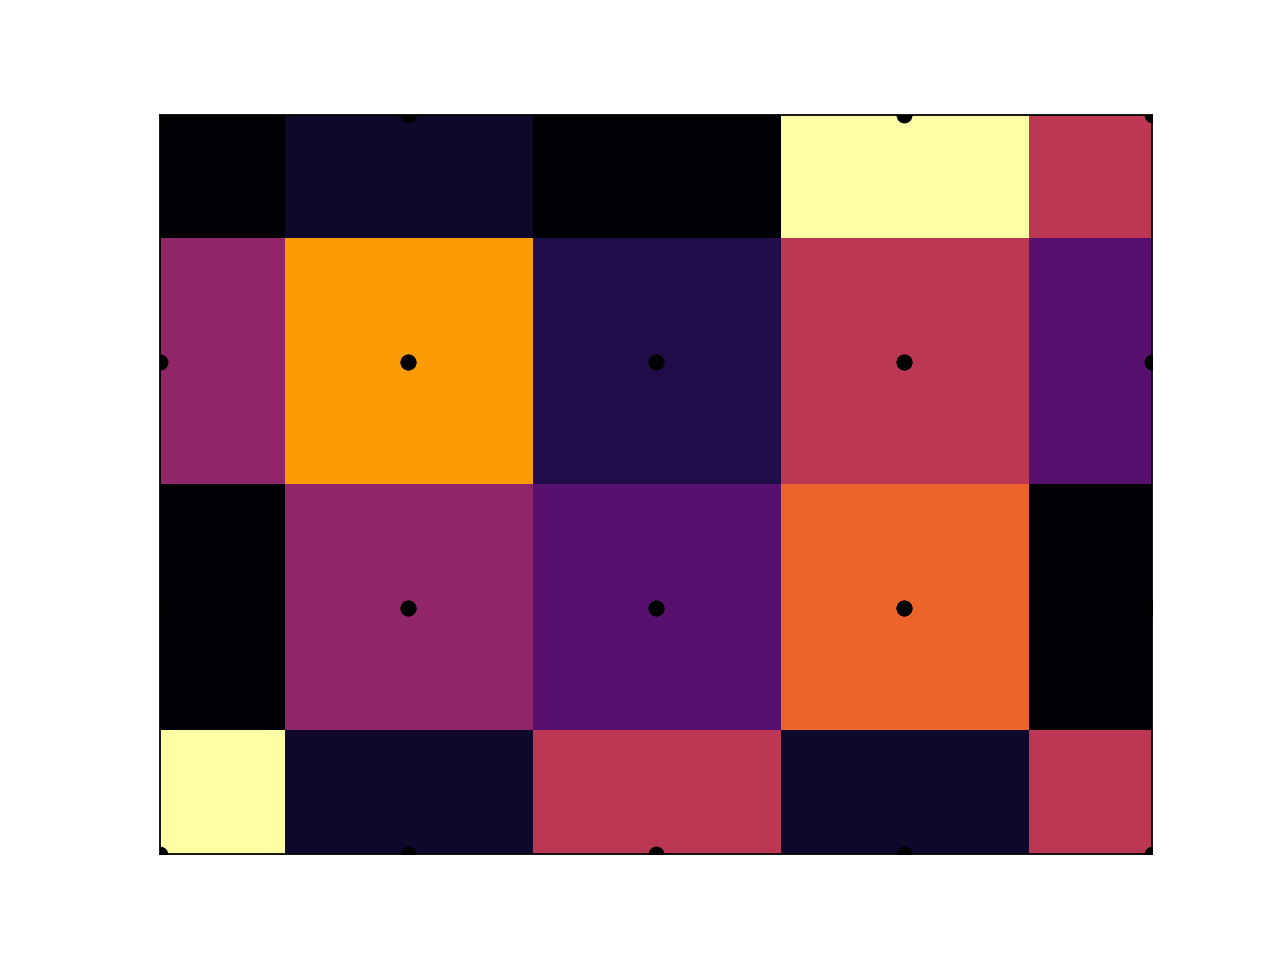

In [93]:
## NEAREST NEIGHBOR INTERPOLATION
#figure size
neighbor = plt.figure(figsize = figuresize, dpi = 128)

def nn(x, y): #return 0, 1, 2, or 3 depending on the corner rounded to
    return np.round((x - x1) / dx) * 2 + np.round((y - y1) / dy)

# plot the tiles
for tileX in range( 0, numTilesX ):
    for tileY in range( 0, numTilesY ):
        # values at corner of tile
        Q = [];
        Q11 = values[(tileY+1) * numValX + tileX]   # Q11 = (x1, y1) - bottom left
        Q12 = values[tileY * numValX + tileX]       # Q12 = (x1, y2) - top left 
        Q21 = values[(tileY+1) * numValX + tileX+1] # Q21 = (x2, y1) - bottom right
        Q22 = values[tileY * numValX + tileX+1]     # Q11 = (x2, y2) - top right
        
        #tile position
        x1 = 0.0 + tileX * dx
        x2 = x1 + dx

        y2 = 1.0 - tileY * dy
        y1 = y2 - dy
        
        r = 100

        x = np.linspace(x1, x2, r)
        y = np.linspace(y1, y2, r)
        X,Y = np.meshgrid(x, y)
        
        P = nn(X,Y)
        P.astype(int)
        C = np.zeros(P.shape)
        
        C[P==0] = Q11
        C[P==1] = Q12
        C[P==2] = Q21
        C[P==3] = Q22
        
        #plot colors for equal values
        plt.pcolormesh(X, Y, C, cmap = colormap, vmin = minval, vmax = maxval)
        plt.plot([x1, x2, x1, x2], [y1, y1, y2, y2], 'ko')
        
        #show lines in contour plot
        #C = plt.contour(X, Y, f(X, Y), levels, colors = 'black', alpha=.8, linewidth = 1)
        
        #show labels in contour plot
        #plt.clabel(C, inline = 1, fontsize = 7, fmt = '%d')
plt.xticks([])
plt.yticks([])
neighbor.show()

# Bicubic Interpolation 

<IPython.core.display.Javascript object>


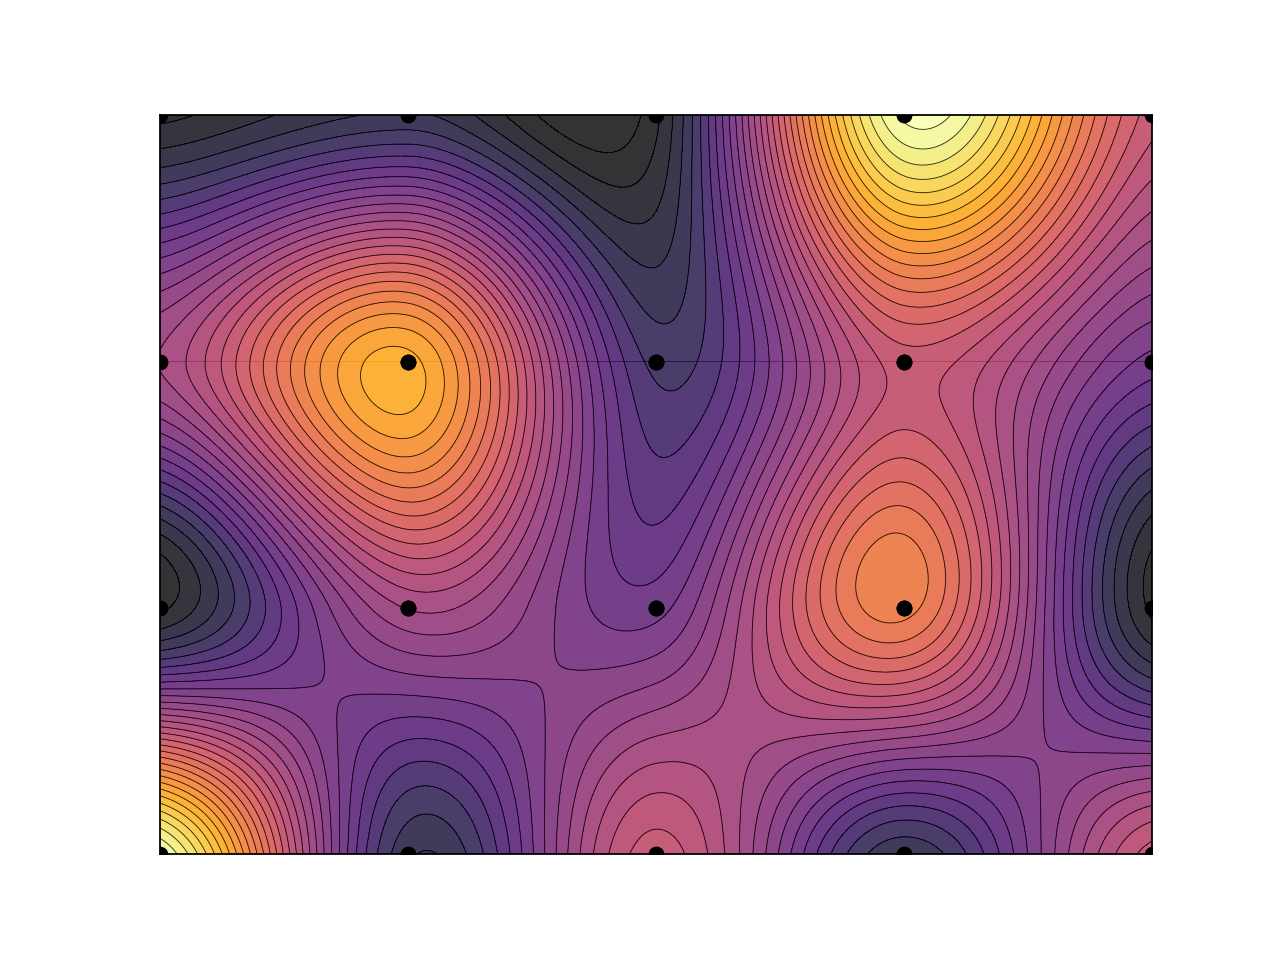

In [90]:
## BICUBIC INTERPOLATION

#figure size
bic = plt.figure(figsize = figuresize, dpi = 128)

def cubic(p, t):
    return p[1] + 0.5 * t*(p[2] - p[0] + t*(2.0*p[0] - 5.0*p[1] + 4.0*p[2] - p[3] + t*(3.0*(p[1] - p[2]) + p[3] - p[0])));

def bicubic(p, x, y):
    cx = []
    cx.append(cubic(p[0], x))
    cx.append(cubic(p[1], x))
    cx.append(cubic(p[2], x))
    cx.append(cubic(p[3], x))
    return cubic(cx, y)
        
# plot the tiles
for tileX in range( 0, numTilesX ):
    for tileY in range( 0, numTilesY ):
        
        # values at corner of tile
        l = tileX
        r = tileX + 1
        t = tileY
        b = tileY + 1
        
        #neighboring tiles
        ll = l - 1
        rr = r + 1
        ll = max(ll, 0)
        rr = min(rr, numTilesX)
        
        tt = t - 1
        bb = b + 1
        tt = max(tt, 0)
        bb = min(bb, numTilesY)
        
        p = []     
        p.append([values[bb * numValX + ll], values[bb * numValX + l], values[bb * numValX + r], values[bb * numValX + rr]])
        p.append([values[ b * numValX + ll], values[ b * numValX + l], values[ b * numValX + r], values[ b * numValX + rr]])
        p.append([values[ t * numValX + ll], values[ t * numValX + l], values[ t * numValX + r], values[ t * numValX + rr]])
        p.append([values[tt * numValX + ll], values[tt * numValX + l], values[tt * numValX + r], values[tt * numValX + rr]])
        
        #tile position
        x1 = 0.0 + tileX * dx
        x2 = x1 + dx

        y2 = 1.0 - tileY * dy
        y1 = y2 - dy

        n = 256
        #create grid between 0 and 1
        x = np.linspace(0, 1, n)
        y = np.linspace(0, 1, n)
        X, Y = np.meshgrid(x, y)
        Z = bicubic(p, X, Y)
        
        #create grid between tile coordinates
        x = np.linspace(x1, x2, n)
        y = np.linspace(y1, y2, n)
        X, Y = np.meshgrid(x, y)
        
        #plot colors for equal values
        plt.contourf(X, Y, Z, levels, alpha=.8, cmap = colormap, vmin = minval, vmax = maxval)
        
        #show lines in contour plot
        C = plt.contour(X, Y, Z, levels, colors = 'black', alpha=.8, linewidths = 0.4)
        
        #show labels in contour plot
        #plt.clabel(C, inline = 1, fontsize = 7, fmt = '%.2f')

        #plot points at corners
        plt.plot([x1, x2, x1, x2], [y1, y1, y2, y2], 'ko')
plt.xticks([])
plt.yticks([])

bic.show()

<IPython.core.display.Javascript object>


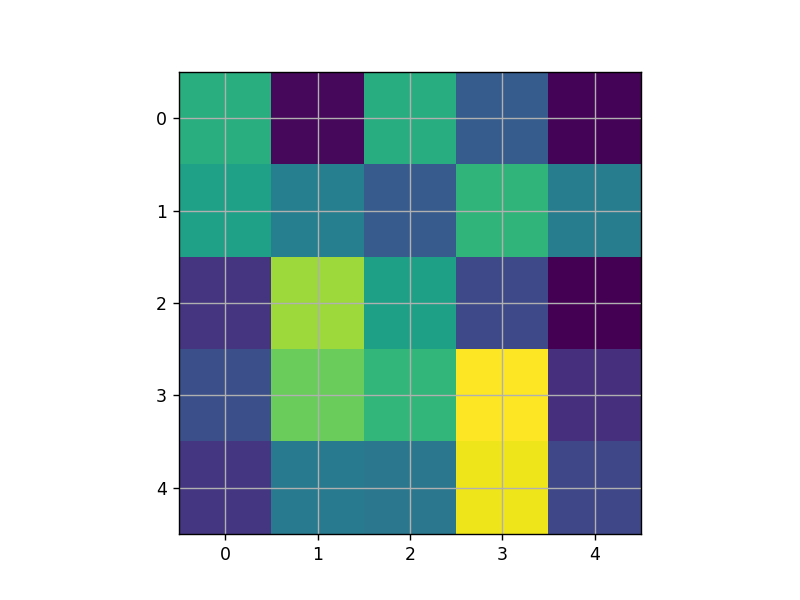

<IPython.core.display.Javascript object>


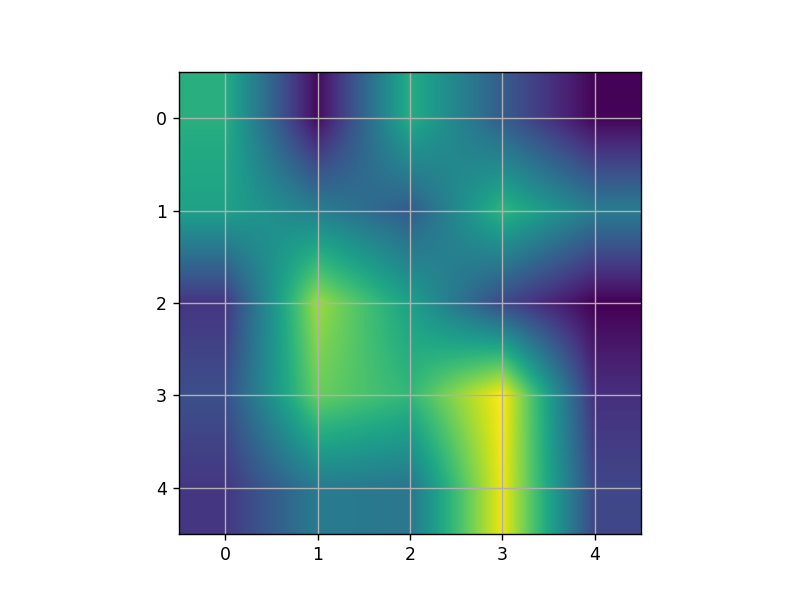

<IPython.core.display.Javascript object>


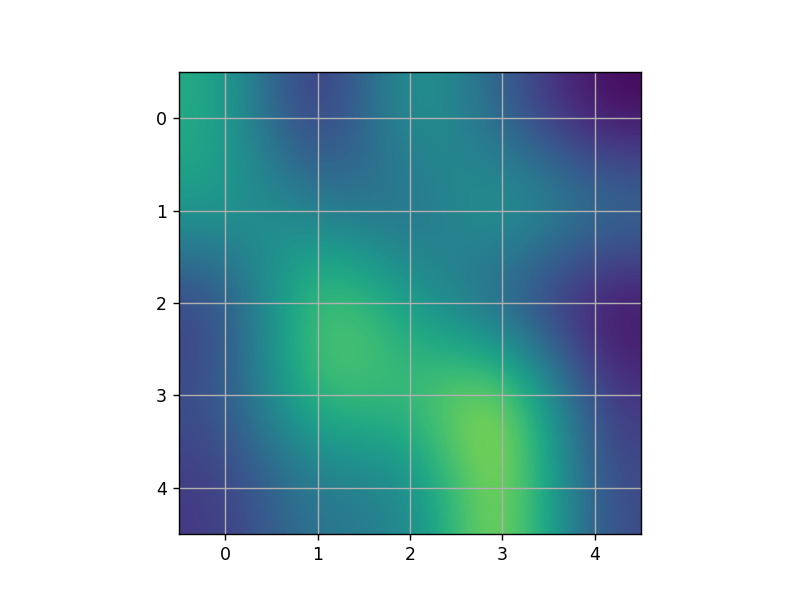

In [79]:
A = np.random.rand(5, 5)
n = plt.figure()
plt.imshow(A, interpolation='nearest')
plt.grid(True)

bl = plt.figure()
plt.imshow(A, interpolation='bilinear')
plt.grid(True)

bc = plt.figure()
plt.imshow(A, interpolation='bicubic')
plt.grid(True)

plt.show()